# Salary Predictions Based on Job Feature Descriptions

# Part 1 - DEFINE

### ---- 1 The problem ----

Examine a set of job postings with salaries and then predict salaries for a new set of job postings.

Data supplied
Three CSV data files:
• train_features.csv: Each row represents metadata for an individual job posting.
    The “jobId” column represents a unique identifier for the job posting. The remaining columns describe features of the job posting.
• train_salaries.csv: Each row associates a “jobId” with a “salary”.
• test_features.csv: Similar to train_features.csv, each row represents metadata for an individual job posting. 

The task
Build a model to predict the salaries for the job postings contained in test_features.csv. The output will be a CSV file entitled test_salaries.csv where each row has the following format: 
jobId, salary mirroring the format of train_salaries.csv. 

Baseline Sucess Measure: MSE under 360

Deliverables
• test_salaries.csv file containing the salary predictions for the test data set.
• Data Exploration (EDA) file: Salary-Predictions-EDA.ipynb (this file) 
• Solution Code file: Salary-Prediction-Analysis.ipynb (in this repository) 


Revision 1.0
Solution is a Python 3.0 analysis
Utilizing numpy, Pandas, sklearn, matplotlib, and seaborn packages 


# Import Packages
***

In [1]:
#your info here
__author__ = "Bob Stephens"
__email__ = "rwstephens6@gmail.com"

In [1]:
#import Python libraries for dataframes and analytics
import pandas as pd
import sklearn as sk

# Import the neccessary modules for data manipulation and visual representation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

# Load sklearn tools to perform model analysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

## Helpers - useful functions tuned for this solution

In [2]:
# Feature EDA Functions
    
# Plot Feature Functions 
def plotf_hist(df, bns):
    df.hist(bins=bns)
    
def plotf_df(df):
    print("plot data")
    plt = plotf(df,50) #Histogram
    plt.show()

### ---- Define and Load the data ----

In [24]:
#load data
# Read in Train and Test Data (Features and Salaries)

print("Loading data")
tr_feature_df = pd.read_csv('data/train_features.csv')
tr_target_df  = pd.read_csv('data/train_salaries.csv')
test_df  = pd.read_csv('data/test_features.csv')

Loading data


## Data Discovery

In [4]:
tr_feature_df.info()
#Info tells us the training data 1 Million records, 8 columns, all columns non null and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [9]:
tr_feature_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [22]:
#  describe the data for further undertstandings of the values
tr_feature_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


For Assuming Min = 0 in both examples denotes < 1 above


Review Categorical Data 

In [24]:
# look at the Category data /non numerical data points
tr_feature_df.describe(include='object')

#Notice JobID is unique for each row

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362685187893,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


jobId is unique to each line - not useful in Model 
NONE is > 50% of values in Major - to reviwe more closely for validity 

Review Target data

In [10]:
#review TEST Data Set 

test_df.info()

# TEST data also equals 1 Million records, 8 columns, all columns non null and data type
# and Train and test are the same header - reasonable to assume test data is in same format as train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [12]:
# Target/Salary info 
tr_target_df.info()

# target/salary also has Million records and it appears we can consolidate the features and salary based on Job ID

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [14]:
tr_target_df.head(10)

#Noting Salaries values are in hundreds, we will assume these are annual salaries (in thousands) 

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [4]:
tr_target_df.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


Min is 0, max is 301.  Assuming this be $0 - $301,000 annual salary ($0 seems incorrect)

No need to change format as it can be estimated in same format, will address 0's in conslidated dataset

### ---- Conslidate and Clean train data ----

In [5]:
# Feature EDA Functions
    
# Plot Variable Functions 
def plotv_df(df, bns):
    print("plot data")
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    sns.boxplot(df)
    plt.subplot(1,2,2)
    # sns.distplot(df, bins=20)
    df.hist(bins=bns)
    plt.show()

In [6]:
#define features and feature types from review

#define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
                  
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

In [25]:
#consolidate training data
# Lets use Inner join to emove any match not in either file,  and eliminate any duplicates 
# merge on jobId
# validate="one_to_one" to make sure there are no duplicate jobId's

train_df = pd.merge(left=tr_feature_df, right=tr_target_df, how='inner', on='jobId', validate="one_to_one")

In [6]:
train_df.shape

# appears all features/salary is one to one - all rows merged 

(1000000, 9)

Look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
We can see there is some data that is 0 ie min()=0 yearsExperience, milesFromMetropolis, salary
Explore and determine clean up method for consideration later:  drop_duplicates(), remove or impute invalid values

In [42]:
train_df.isnull().any()
# no Nulls
#df_features_train['companyId'].isnull().sum()
#df_features_train['jobType'].isnull().sum()
#df_features_train['degree'].isnull().sum()
#df_features_train['major'].isnull().sum()
#df_features_train['industry'].isnull().sum()
# all Null data sums are 0 so no Nulls

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [43]:
train_df.duplicated().sum()

0

In [44]:
train_df.describe(include='all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362685355182,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


Visualize Variables 
- starting with Target

plot data


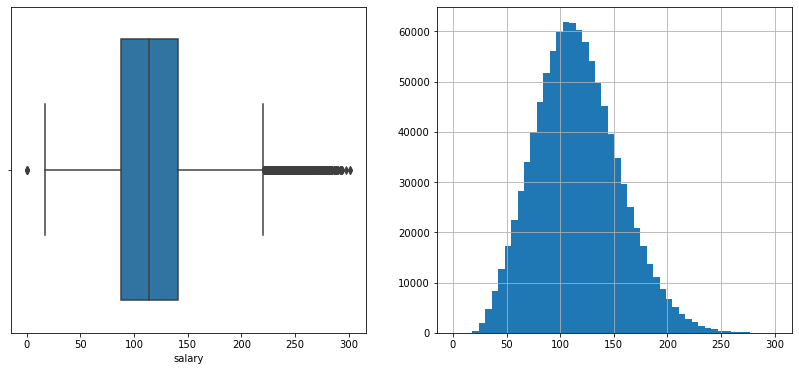

In [45]:
plotv_df(train_df.salary, 50)

Close to a normal distibution - however appears to skewed to the Positive

Outliers 0 and > 200 - Reviewing Further - will consider adjusting for linear regression models

In [46]:
skews = train_df.skew()
skews

# Salary data may be positiviely skewed.  
# We will look at this more closely since it the depandant target and to ensure more accurate prediction models. 

yearsExperience        0.001674
milesFromMetropolis   -0.001139
salary                 0.346415
dtype: float64

Use IQR rule to identify potential outliers

In [26]:
stat = train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [48]:
#check potential outlier below lower bound or train_df[train_df['salary'] == 0]
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [50]:
#check potential outlier above upper bound
train_df.loc[train_df.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

In [51]:
train_df[(train_df.salary > 222.5) & (train_df.jobType == 'JUNIOR')].head(20)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


In [52]:
# Senior Postions coudl have higher than normal Salaries given DR degree, length of service or even Industry. 

# Checking more suspicious potential outliers above upper bound
train_df[(train_df.salary > 222.5) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


Five Entries have 0 Salary - 
- Impute or Drop rows?  Better to drop rows than assume values   

These entries with zero salary based on other features, do not appear to be valid - and not to be volunteer positions. 
Five values of salary that are 0 and why would that ever be the case? 

We are confident that they are instances of missing/corrupt data since it's only 5 values or .0005% that should have little impact on the results. Should be removed from the training set.

The high-salary potential outliers  appear to be legitimate data. Or a least we cannot rule any out. Most roles are C-level executive roles and the junior positions are in industries that are well known for high salaries (oil, finance). We determine these entries to be legitimate and will not remove them.

In [27]:
# Remove data with zero salaries
train_df = train_df[train_df.salary > 8.5]

In [63]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### ---- Explore further the Cleaned data (EDA) ----

In [10]:
def plot_feat(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        # df[col].value_counts().sort_index().plot()
        sns.regplot(x=col, y='salary',data=df)
        plt.ylim(0,)
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    # Plot to crowded to review with all rows -  
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()


In [ ]:
# summarize each feature variable
# reviewing for relationship between Features and Target 
# target is Salary
# look for correlation between each feature and the target
# look for correlation between features

In [68]:
numeric_vars

['yearsExperience', 'milesFromMetropolis']

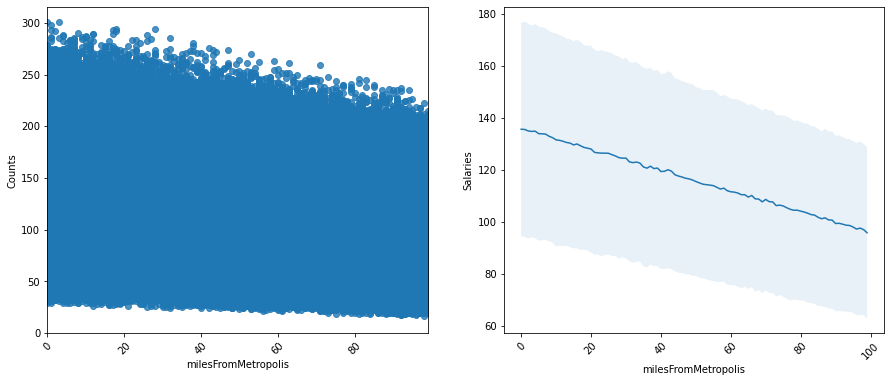

In [71]:
#milesFromMetropolis
plot_feat(train_df, 'milesFromMetropolis')

# - Linear - As suspected some Negative Impact 
# In general, salaries decrease with the distance to metropolis.

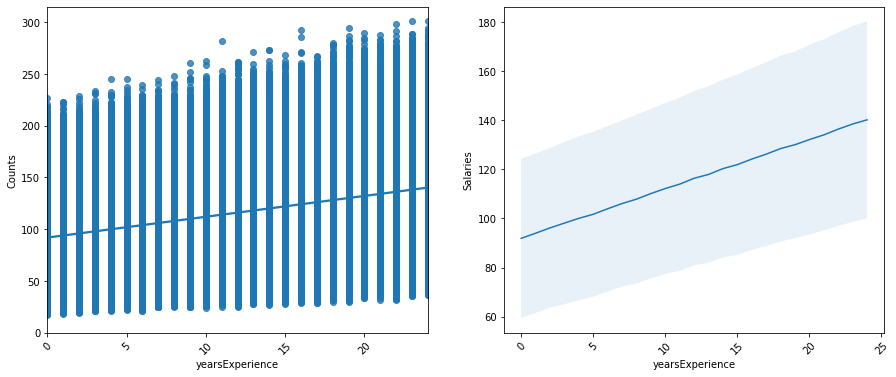

In [72]:
# yearsExperience 
plot_feat(train_df, 'yearsExperience')

#Positive Linear Impact
# In general, there is a correlation between salary and years of experience.

Outliers skewed above the 75% at all points, but mean seems to be distributed as expected
Supporting impact of Postive Skew in the Salary. 

- For Miles the closer the resource the higher the mean - the exception outliers at what appear to be all mileages could indicate that rule may not apply to all jobtypes
- Same exception for years experience

Look at groupings by Categorical Vars to see correlation  

In [69]:
categorical_vars

['companyId', 'jobType', 'degree', 'major', 'industry']

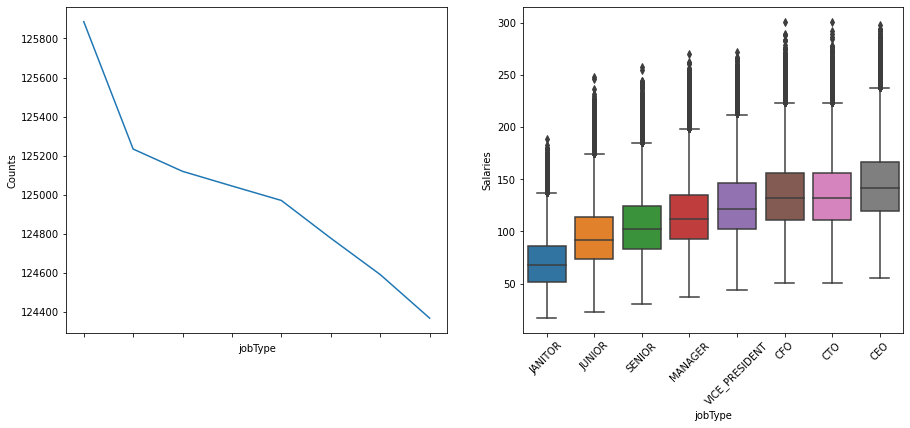

In [73]:
# jobType 
plot_feat(train_df, 'jobType')

# Appears to be some Positive Linear Impact by Job TYpe

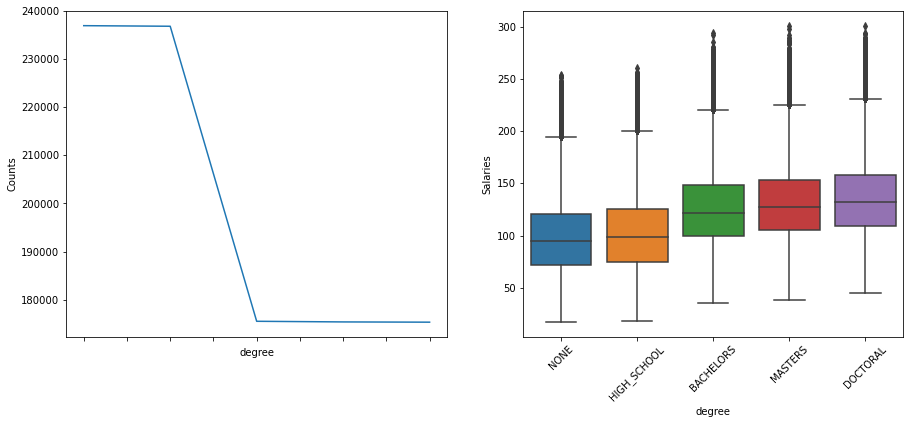

In [74]:
# degree 
plot_feat(train_df, 'degree')

# Appears to be some Positive Linear Impact by degree

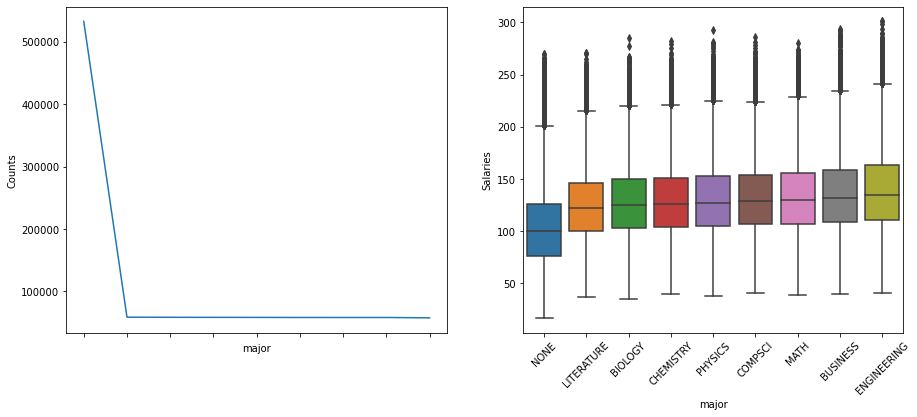

In [75]:
# major 
plot_feat(train_df, 'major')

# Appears to be some small Positive Linear Impact by Major  - NONE Major has larger variance 

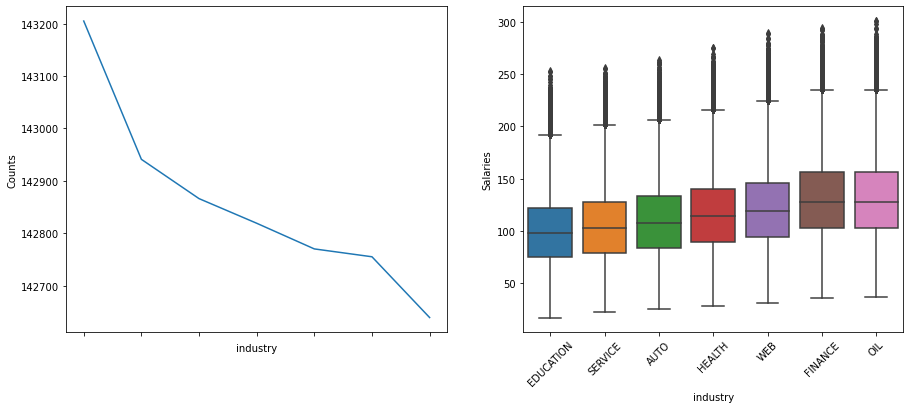

In [76]:
# industry 
plot_feat(train_df, 'industry')

# Appears to be some Positive Linear Impact by industry

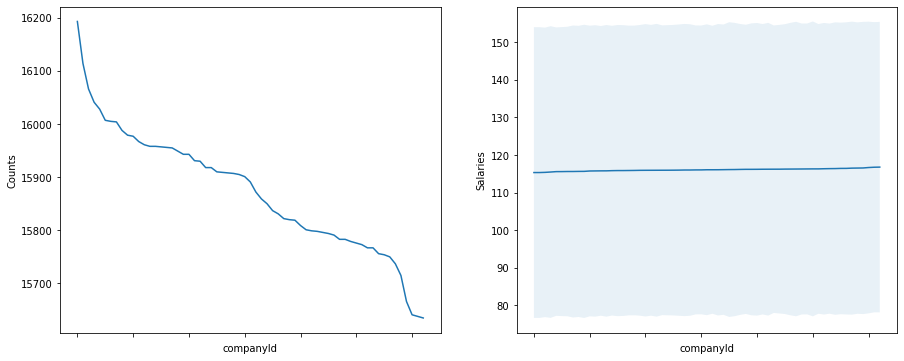

In [77]:
# companyId 
plot_feat(train_df, 'companyId')

# Hard to determine impact to Salary -small Positive  Impact if any

Dropping Jobid unique for each line so it has no value in the model. 

Reviewing companyId, jobType, degree, major, industry all have limited Unique values so we could use "Dummy Encoding" and "Label Encoding" depending on Ordinality. 

Look for Categorical Ordinals or Nominals, also looks mispellings (Duplicates) in jobType, degree,  major , industry
.value_counts()

In [79]:
train_df.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [80]:
train_df.degree.value_counts()

HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64

In [81]:
train_df.major.value_counts()

NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64

In [82]:
train_df.industry.value_counts()

WEB          143205
AUTO         142941
FINANCE      142866
EDUCATION    142819
OIL          142770
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

In [83]:
#df_train.industry.unique()
train_df.companyId.value_counts()

COMP39    16193
COMP35    16114
COMP59    16066
COMP30    16041
COMP3     16028
          ...  
COMP17    15715
COMP0     15666
COMP2     15641
COMP8     15638
COMP57    15635
Name: companyId, Length: 63, dtype: int64

In [ ]:
"Major" feature appears possibly unbalanced - "NONE" is > %50 more - and the remaining values are normally distributed
One thought would be to drop NONE as "Major" value ... TBD - Degree appears to have 'NONE' Value as well

In [27]:
# Looking at CompanyId values closer 

df_small = df_train[["companyId","salary"]]
df_grp = df_small.groupby(["companyId"], axis=0).sum().sort_values("salary")
df_grp

# NO significant differences in salaries between companies 

,salary
companyId,
COMP57,1804178
COMP8,1813846
COMP0,1816686
COMP53,1819641
COMP31,1821744
...,...
COMP3,1862443
COMP35,1865593
COMP44,1867477


In [84]:
# Features review
# companyId = On the surface may not appear to be a factor but given there are only 63 unique vales we might find the the salary is related
# jobType = Should be a high correlation  given 8 unique values this may be a good candidate for making an ordinal(1-8)
# degree = Could be a med correlation given 8 unique values this may be a good candidate for making ordinal (1-8)
# major = Could be a med correlation : Nominal? 
# industry = Should be a high correlation : Nominal?
# yearsExperience = Should be a high correlation
# milesFromMetropolis = Negative factor 

#Look for correlations

corr = train_df.corr()
corr

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

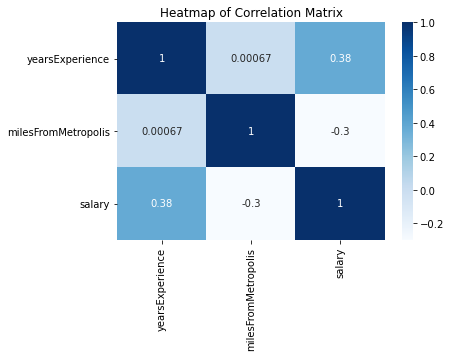

In [85]:
# Visualize correlations in a Heatmap for more clarity
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap ="Blues", annot=True
           )
plt.title('Heatmap of Correlation Matrix')

# milesFromMetropolis has Intersting Negative Impact 

#perhaps Normalizing Years and Miles would be helpful - we'll see as we start applying statiscal analysis

# Would like to see Categorical data in this Heat Map as well - 

In [86]:
# Use Cat.codes to set up Correlation Matrix with Objects

new = train_df.assign(jobType=train_df.jobType.astype('category').cat.codes)
new = new.assign(degree=new.degree.astype('category').cat.codes)
new = new.assign(major=new.major.astype('category').cat.codes)
new = new.assign(industry=new.industry.astype('category').cat.codes)
new = new.assign(companyId=new.companyId.astype('category').cat.codes)

new_corr = new.corr()
new_corr

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
companyId,1.000000,0.004762,0.003679,0.003814,0.002341,0.001981,-0.002447,0.008309
jobType,0.004762,1.000000,0.201779,0.167442,0.002146,0.001061,-0.000212,0.578922
degree,0.003679,0.201779,1.000000,0.638639,0.001305,0.000217,0.001785,0.384044
major,0.003814,0.167442,0.638639,1.000000,-0.000168,-0.000114,0.001128,0.346213
industry,0.002341,0.002146,0.001305,-0.000168,1.000000,0.000624,-0.001158,0.293894
yearsExperience,0.001981,0.001061,0.000217,-0.000114,0.000624,1.000000,0.000672,0.375013
milesFromMetropolis,-0.002447,-0.000212,0.001785,0.001128,-0.001158,0.000672,1.000000,-0.297686
salary,0.008309,0.578922,0.384044,0.346213,0.293894,0.375013,-0.297686,1.000000


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

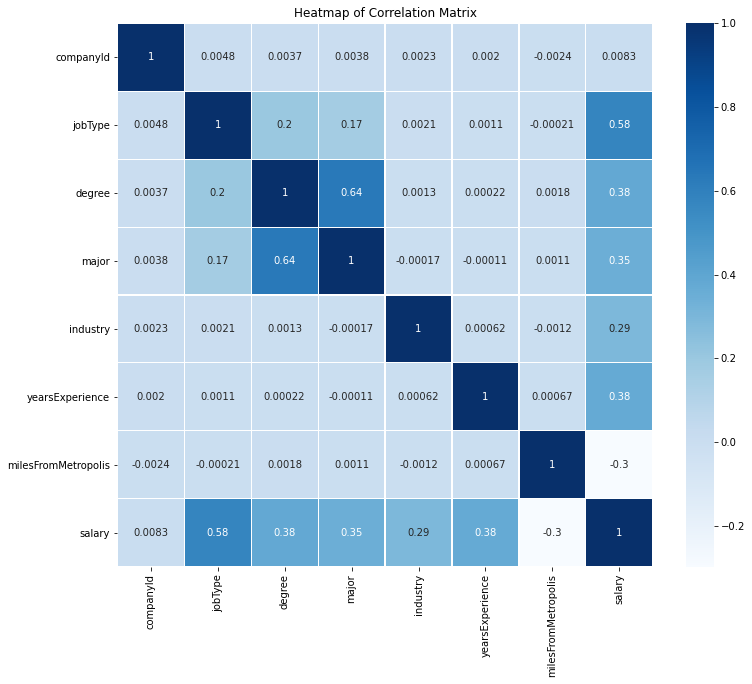

In [87]:
# Visualize correlations in a Heatmap for more clarity  
#        # Sample figsize in inches

fig, ax = plt.subplots(figsize=(12,10))  
sns.heatmap(new_corr, 
            xticklabels=new_corr.columns.values,
            yticklabels=new_corr.columns.values,
            cmap ="Blues", annot=True,linewidths=.1, ax=ax
           )
plt.title('Heatmap of Correlation Matrix')


We see that jobType is most strongly correlated with salary, followed by degree, major, and yearsExperience.
CompanyID has very little correlation

Among the features, we see that degree and major have a strong degree of correlation and jobType has a moderate degree of correlation with both degree and major.

Explore grouping 

In [91]:
#Group BYs jobType, degree,  major , industry and sales 
df_gtest=train_df[["jobType","degree","major","industry","salary"]]

df_grp = df_gtest.groupby(["major","degree"], as_index=False).mean()

In [92]:
df_pivot = df_grp.pivot(index="major", columns = "degree")
df_pivot

salary                                                
degree            NONE HIGH_SCHOOL   BACHELORS     MASTERS    DOCTORAL
major                                                                 
NONE         98.176882  101.921085  117.814699  123.119950  128.314773
LITERATURE         NaN         NaN  119.335256  124.215313  129.674594
BIOLOGY            NaN         NaN  123.204343  127.744510  132.900799
CHEMISTRY          NaN         NaN  123.906966  129.095825  134.241379
PHYSICS            NaN         NaN  125.209302  130.622320  135.252974
COMPSCI            NaN         NaN  126.965316  132.436852  136.887929
MATH               NaN         NaN  128.211868  133.334637  138.394916
BUSINESS           NaN         NaN  130.890071  135.809151  140.227459
ENGINEERING        NaN         NaN  133.522468  138.186407  143.678077

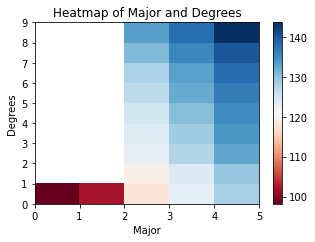

In [93]:
headers = df_grp.columns

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

heatmap = ax.pcolor(df_pivot, cmap="RdBu")
cbar = plt.colorbar(heatmap)

plt.title('Heatmap of Major and Degrees')
plt.xlabel('Major')
plt.ylabel('Degrees')

plt.show()

Clearly the NONE Value of Major is the Correlation base on Number
- consider how this might factors into the Model

In [96]:
df_grp = df_gtest.groupby(["jobType","degree"], as_index=False).mean()

df_pivot1 = df_grp.pivot(index="jobType", columns = "degree")  
df_pivot1


salary                                                
degree                NONE HIGH_SCHOOL   BACHELORS     MASTERS    DOCTORAL
jobType                                                                   
JANITOR          70.649575   70.976821         NaN         NaN         NaN
JUNIOR           80.884064   85.791986   98.130267  103.463304  108.356035
SENIOR           90.628738   95.908637  108.325539  113.408824  118.867134
MANAGER         100.981070  106.068086  118.173795  123.389176  128.211800
VICE_PRESIDENT  111.207654  115.758343  128.196227  133.077062  138.491400
CFO             121.135389  125.964395  138.508706  143.316243  148.308742
CTO             120.939193  126.082232  138.363172  143.582019  148.269262
CEO             130.796690  135.629182  148.421009  153.254510  158.232849

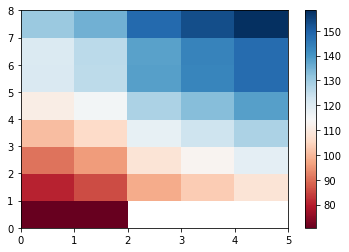

In [97]:
plt.pcolor(df_pivot1, cmap="RdBu")
plt.colorbar()
plt.show()

'JANITOR' / 'NONE' or 'HIGH SCHOOL' - maks sense a JANITOR does not have higher degree 


### ---- 4.1 Pre Process the data ----

Transform the Categorical variables for Modeling.  

Will drop Jobid - unique for each line so it has no value in the model. 

companyId,jobType, degree, major, industry all have limited Unique values 
so we use "Dummy and Ordinal Encoding" to create numerical Rows

Does Company Id have any value? 
Hypothesis each company could pay at a differnt rate so it could necessary be to properly predict 
if we include the compancy id as a Dummy, but the prediction has a Company ID not in our Training data then we've limited our predictions to these companies - Will try dropping and labeling to see which might have better impact. 

Choosing not to Rescale the data for now - the Predictors and Target are generally in the same scale -
May help with Tuning - may look at this futher after we have some results

Consider adding "Grouped feature"(s) given probable correlations between degree and major and jobType.


In [11]:
# Define and Consolidate Functions utilized to analyze the data and prediction Models for this solution
class feature:
  def __init__(self, featname, feattype):
    self.featname = featname
    self.feattype = feattype

  def pfeat(self):
    print("Feature is ", self.featname," type is ", self.feattype)

def logfunc(x):
    return np.log(x)
def inverse_logfunc(x):
    return np.exp(x)

#Label Encoding / OrdinalEncoder
def oneHot_DF(df, cat_feat):
    print('One Hot Encoding: ', cat_feat)
    dum_feats = pd.get_dummies(df[cat_feat]).rename(columns=lambda x: cat_feat + str(x))
    return pd.concat([df,dum_feats], axis=1)
    
# def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
#     '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
#     cat_df = pd.get_dummies(df[cat_vars])
#     num_df = df[num_vars].apply(pd.to_numeric)
#     return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)
    
def labelenc_DF(df, name):
    print('Label Encoding: ', name)
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    # Assigning numerical values and storing in another column
    df[name] = labelencoder.fit_transform(df[name])
    return df

# Ordinals limits the number of extra columns and sets categorical values to numerics
#  values in Degrees and JObType columns are candidates
def ordinal_DF(df, feature):
    print('Ordinal Encoding: ', feature)
    # Specific for this data set
    degree_ord_map = {
    'NONE': 0,
    'HIGH_SCHOOL': 1,
    'BACHELORS': 2,
    'MASTERS': 3,
    'DOCTORAL': 4}  
    
    # Set/replace 'Job Type' to Ordinal value for Predictive Model'
    jobtype_ord_map = {
    'JANITOR': 0,
    'JUNIOR': 1,
    'SENIOR': 2,
    'MANAGER': 3,
    'CFO': 4,
    'CTO': 5,
    'VICE_PRESIDENT': 6,
    'CEO': 7 }
    
    if feature in ['degree']:
        df[feature] = df[feature].map(degree_ord_map)
    elif feature in ['jobType']:
        df[feature] = df[feature].map(jobtype_ord_map)
    else:
        # NO ELSE for this dataset
        df[feature] = df[feature].apply(pd.to_numeric)
    return df

def clean_DF(df):
    '''In this data set remove rows that contain salary <= 0 or duplicate job IDs'''
    print("Dropping duplicates ...")
    df = df.drop_duplicates(subset='jobId')
    #Dropping labels JobID which has no feature Correlation with the Target Salary 
    df.drop("jobId", axis=1, inplace=True)
    # REorder for easier slicing and Clarity
    df=df[df.columns[[7,0,1,2,3,4,5,6]]]
    return df

In [28]:
# prep Data for testing Models 
prep_df = train_df[:]

#clean, shuffle, and reindex training data 
prep_df = clean_DF(prep_df).reset_index()

#get target df
target_df = prep_df[target_var]

Dropping duplicates ...


In [10]:
prep_df.head()

,index,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,0,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,1,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,2,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,3,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,4,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


Feature Generation (Groupings) - n do this before converting Cats to Numeric to avoid grouping index issues

Group by degree and major and jobType 
Add Statistical target values that could provide highler level correlations (Mean and Median make the most sense) 

In [29]:
cat_cols = ['jobType', 'degree', 'major', 'industry'] #added industry
target_col = ['salary']

In [ ]:
#group_stats_df['group_max'] = groups[target_col].max()
#group_stats_df['group_min'] = groups[target_col].min()
#group_stats_df['group_std'] = groups[target_col].std()
#group_stats_df['group_median'] = groups[target_col].median()

# group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
group_stats_cols = ['group_mean', 'group_median']

In [63]:
group1 = (prep_df.groupby(cat_cols, as_index=False).agg({'salary':'mean'}).rename(columns={'salary':'group_mean'}))

In [64]:
group1.head()

,jobType,degree,major,industry,group_mean
0,CEO,BACHELORS,BIOLOGY,AUTO,139.256477
1,CEO,BACHELORS,BIOLOGY,EDUCATION,125.694301
2,CEO,BACHELORS,BIOLOGY,FINANCE,159.640506
3,CEO,BACHELORS,BIOLOGY,HEALTH,156.771290
4,CEO,BACHELORS,BIOLOGY,OIL,159.422500


In [60]:
group2 = (prep_df.groupby(cat_cols, as_index=False).agg({'salary':'median'}).rename(columns={'salary':'group_median'}))

In [61]:
group2.head()

,jobType,degree,major,industry,group_median
0,CEO,BACHELORS,BIOLOGY,AUTO,138.0
1,CEO,BACHELORS,BIOLOGY,EDUCATION,122.0
2,CEO,BACHELORS,BIOLOGY,FINANCE,159.0
3,CEO,BACHELORS,BIOLOGY,HEALTH,155.0
4,CEO,BACHELORS,BIOLOGY,OIL,155.5


In [65]:
group_stats_df = pd.merge(group1, group2, on=cat_cols, how='left')

In [66]:
group_stats_df.head()

,jobType,degree,major,industry,group_mean,group_median
0,CEO,BACHELORS,BIOLOGY,AUTO,139.256477,138.0
1,CEO,BACHELORS,BIOLOGY,EDUCATION,125.694301,122.0
2,CEO,BACHELORS,BIOLOGY,FINANCE,159.640506,159.0
3,CEO,BACHELORS,BIOLOGY,HEALTH,156.771290,155.0
4,CEO,BACHELORS,BIOLOGY,OIL,159.422500,155.5


In [67]:
prep_df = pd.merge(prep_df, group_stats_df, on=cat_cols, how='left')

In [68]:
# if a valid grouping does not exist 
prep_df.fillna(0, inplace=True)

In [69]:
prep_df.head()

,index,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,group_mean,group_median
0,0,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,141.246753,139.0
1,1,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,140.051566,138.0
2,2,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,133.640097,132.0
3,3,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,118.915865,117.0
4,4,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,142.290323,140.0


In [99]:
categorical_vars

['companyId', 'jobType', 'degree', 'major', 'industry']

For Non Ordered values Create the Dummy rows 
For Ordinals like Job Type, and degree 

In [71]:
# define feature types for each feature in data set
# utilized in various interations to TUNE(optimize) params for Models based on EDA findings
# 1 labels ['companyId', 'major'], ordinals ['jobType','degree'], One Hot Encoding ['industry'] 
# 2 labels ['companyId'], ordinals ['jobType','degree'], One Hot Encoding ['industry', 'major']
# 3 labels [], ordinals ['jobType','degree'], One Hot Encoding ['companyId','industry', 'major']
# 4 labels ['companyId'], ordinals [], One Hot Encoding ['industry', 'major','jobType','degree']
# 6 labels [], ordinals [], One Hot Encoding ['companyId','industry', 'major','jobType','degree']
features = []
for cat in categorical_vars:
    if cat in ['companyId', 'major']:
        features.append(feature(cat,'label'))
    elif cat in ['jobType','degree']:
        features.append(feature(cat,'ord'))
    else:
        features.append(feature(cat,'hot'))

In [72]:
for feat in features:
    feat.pfeat()
    if feat.feattype == 'label':
         # Label Encoding
        prep_df = labelenc_DF(prep_df,feat.featname)
    elif feat.feattype == 'hot':
         # One Hot Encoding
        prep_df = oneHot_DF(prep_df,feat.featname)
        prep_df.drop(feat.featname, axis=1, inplace=True)
        # Dropping 'NONE' as a Major - Statitical speaking the K-1 / No Major value 
        if (feat.featname == "major") and ("majorNONE" in prep_df.columns):
             prep_df.drop("majorNONE", axis=1, inplace=True)
    elif feat.feattype == 'ord':
        df_feat = ordinal_DF(prep_df,feat.featname)
    
# prep_df[num_vars] = prep_df[num_vars].apply(pd.to_numeric)

Feature is  companyId  type is  label
Label Encoding:  companyId
Feature is  jobType  type is  ord
Ordinal Encoding:  jobType
Feature is  degree  type is  ord
Ordinal Encoding:  degree
Feature is  major  type is  label
Label Encoding:  major
Feature is  industry  type is  hot
One Hot Encoding:  industry


In [73]:
prep_df.head()

,index,salary,companyId,jobType,degree,major,yearsExperience,milesFromMetropolis,group_mean,group_median,industryAUTO,industryEDUCATION,industryFINANCE,industryHEALTH,industryOIL,industrySERVICE,industryWEB
0,0,130,31,4,3,6,10,83,141.246753,139.0,0,0,0,1,0,0,0
1,1,101,11,7,1,7,3,73,140.051566,138.0,0,0,0,0,0,0,1
2,2,137,48,6,4,8,10,38,133.640097,132.0,0,0,0,1,0,0,0
3,3,142,32,3,4,2,8,17,118.915865,117.0,1,0,0,0,0,0,0
4,4,163,60,6,2,8,8,16,142.290323,140.0,0,0,1,0,0,0,0


In [74]:
prep_df.shape

(999995, 17)

In [147]:
# Visualize correlations in a Heatmap for more clarity  
#  
prep_corr = prep_df.corr()
prep_corr

,index,salary,companyId,jobType,degree,major,yearsExperience,milesFromMetropolis,AUTO,EDUCATION,FINANCE,HEALTH,OIL,SERVICE,WEB
index,1.000000,-0.000794,0.000617,-0.001162,0.000449,0.000132,0.000913,0.001896,-0.000742,0.001586,-0.000738,-0.000534,-0.000478,-0.000416,0.001321
salary,-0.000794,1.000000,-0.000993,0.550478,0.384028,-0.262430,0.375013,-0.297666,-0.069913,-0.175148,0.154847,-0.003439,0.156959,-0.122361,0.058949
companyId,0.000617,-0.000993,1.000000,-0.001758,0.000450,0.000780,0.001185,-0.001020,0.000581,0.002730,-0.001247,-0.001196,0.000072,-0.000434,-0.000505
jobType,-0.001162,0.550478,-0.001758,1.000000,0.201894,-0.143540,0.000955,-0.000772,-0.000988,-0.001179,0.000772,-0.000040,0.001767,-0.000494,0.000163
degree,0.000449,0.384028,0.000450,0.201894,1.000000,-0.547253,0.000219,0.001781,0.000912,-0.000484,0.000298,0.001022,0.000594,-0.002295,-0.000050
major,0.000132,-0.262430,0.000780,-0.143540,-0.547253,1.000000,0.000012,-0.001369,-0.000117,-0.000661,-0.000416,-0.000800,0.001125,-0.000331,0.001197
yearsExperience,0.000913,0.375013,0.001185,0.000955,0.000219,0.000012,1.000000,0.000673,-0.001003,0.000437,0.000981,-0.001105,0.000798,0.000129,-0.000236
milesFromMetropolis,0.001896,-0.297666,-0.001020,-0.000772,0.001781,-0.001369,0.000673,1.000000,0.000343,0.000808,0.000048,-0.000398,-0.000551,0.000687,-0.000936
AUTO,-0.000742,-0.069913,0.000581,-0.000988,0.000912,-0.000117,-0.001003,0.000343,1.000000,-0.166699,-0.166732,-0.166656,-0.166666,-0.166577,-0.166963
EDUCATION,0.001586,-0.175148,0.002730,-0.001179,-0.000484,-0.000661,0.000437,0.000808,-0.166699,1.000000,-0.166647,-0.166571,-0.166582,-0.166492,-0.166878


#LATER in deploy phase
def preprocessor for Trian and test data


### ---- 5 Establish a baseline ----

In [75]:
result=pd.DataFrame({'Model':[],'MSE':[], 'STD':[]})
def print_summary(model, mean_mse, cv_std):
    result = pd.DataFrame({'Model':[model],'MSE':[mean_mse], 'STD':[cv_std]})
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse)
    print('Standard deviation during CV:\n', cv_std)
    return(result)

In [76]:
# need to split the df_prep data in X and Y - where Y = "Salary" column 
# we already have a TEST set (See above) so do we need train_test_split? 

# Create the X and y set
X = prep_df.iloc[:,2:]  

y = prep_df.salary

# Define train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

Utilizing Mean Squared Error(MSE) to measure efficacy during a 5-fold cross-validation
Using  "average salary" in Dummy Regressor model as baseline measure

In [77]:
# Create a dummy regressor as true Baseline
dumBase = DummyRegressor(strategy='mean')

neg_mse = cross_val_score(dumBase, X_train, y_train, cv=5, n_jobs=2, scoring='neg_mean_squared_error')
mean_mse = -1.0*np.mean(neg_mse)
cv_std = np.std(neg_mse)

res = print_summary(dumBase, mean_mse, cv_std)
result = result.append(res)


Model:
 DummyRegressor()
Average MSE:
 1497.5996598993902
Standard deviation during CV:
 5.067700179889097


In [78]:
# Create a LinearRegression to help Tune Parameter

lr = LinearRegression()

neg_mse = cross_val_score(lr, X_train, y_train, cv=5, n_jobs=2, scoring='neg_mean_squared_error')
mean_mse = -1.0*np.mean(neg_mse)
cv_std = np.std(neg_mse)

res = print_summary(lr, mean_mse, cv_std)
result = result.append(res)


Model:
 LinearRegression()
Average MSE:
 371.04713689790384
Standard deviation during CV:
 0.6706416979522142


In [79]:
# 5 Target Log transition- Negative Impact to MSE

from sklearn.compose import TransformedTargetRegressor
regr = TransformedTargetRegressor(regressor=LinearRegression(),func=logfunc,inverse_func=inverse_logfunc)

lrl = regr.fit(X_train, y_train)

y_lrpred = lrl.predict(X_train)

print ('Sk MSE: ' +str(mean_squared_error(y_train,y_lrpred)))

Sk MSE: 417.08771364980083


In [80]:
result

,Model,MSE,STD
0,DummyRegressor(),1497.599660,5.067700
0,LinearRegression(),371.047137,0.670642


### ---- Hypothesize solution ----

review models that may improve results over the baseline models 

Overall dataset appears to have a linear relationship with Salary

1. Linear Regresssion will be first Model - review Tuning Features (Variations in Feature Encoding, Scaling, LogN)
2. RandomForest Regresssion
3. Gradient Boosting Regresssion

New features to try adding to the model based on EDA:  
* From Correlations Group (JobType and Degree) or ( Degree and major) or (JobType, Degree, Major, and Industry) with mean or median salaries for those groups
* Attempted to remove Company ID from the model but actually made the MSE worse. 
* Ordinal and Label Encoding of Categoricals did not seem to help but seems logical